In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Metro Interstate Traffic Volume dataset using a relative path
# ".." goes one folder up from the current working directory (notebooks)
df = pd.read_csv("../additional_material/Metro_Interstate_Traffic_Volume.csv")

# Show the first rows to confirm it worked
df.head()


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


# Initial data inspection

In [45]:
# Show the first rows
display(df.head())

# Show the last rows
display(df.tail())

# Show a random sample of 5 rows
display(df.sample(5, random_state=42))

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
35748,NaN,289.49,0.0,0.0,1,Fog,fog,2017-07-28 07:00:00,6364
147,NaN,279.35,0.0,0.0,1,Clear,sky is clear,2012-10-08 21:00:00,2030
24362,NaN,291.39,0.0,0.0,36,Clouds,scattered clouds,2016-06-22 00:00:00,708
35495,NaN,294.02,0.0,0.0,90,Thunderstorm,thunderstorm,2017-07-19 22:00:00,2029
11010,NaN,268.69,0.0,0.0,64,Mist,mist,2013-12-27 09:00:00,3734


In [46]:
# Overview of column data types and non-null counts
df.info()

print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB
holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
traffic_volume           int64
d

In [47]:
# 4) Parse datetime and check timeframe for gaps
# -------------------------------------------------
# Convert the date_time column to a proper datetime type
df["date_time"] = pd.to_datetime(df["date_time"])

# Check the time range
print("Min timestamp:", df["date_time"].min())
print("Max timestamp:", df["date_time"].max())

# Sort by time and set as index
df_time = df.sort_values("date_time").set_index("date_time")

# Create a full hourly time index between min and max
full_range = pd.date_range(start=df_time.index.min(),
                           end=df_time.index.max(),
                           freq="H")

# Find missing timestamps (time gaps)
missing_timestamps = full_range.difference(df_time.index)
print("Number of missing hourly timestamps:", len(missing_timestamps))

# Optional: check how many observations per year-month (to judge sparsity)
df["year"] = df["date_time"].dt.year
df["month"] = df["date_time"].dt.month
obs_per_month = (
    df.groupby(["year", "month"])
      .size()
      .reset_index(name="n_obs")
      .sort_values(["year", "month"])
)
display(obs_per_month.head(20))  # show first 20 rows as an example

# Example: filter to a denser timeframe (adjust dates if needed)
# Here we keep all observations from 2013-01-01 onward
df_filtered = df[df["date_time"] >= "2013-01-01"].copy()


Min timestamp: 2012-10-02 09:00:00
Max timestamp: 2018-09-30 23:00:00
Number of missing hourly timestamps: 11976


C:\Users\User\AppData\Local\Temp\ipykernel_12284\4274645482.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df_time.index.min(),


,year,month,n_obs
0,2012,10,805
1,2012,11,785
2,2012,12,969
3,2013,1,706
4,2013,2,717
5,2013,3,715
6,2013,4,939
7,2013,5,940
8,2013,6,767
9,2013,7,748


In [48]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


display(obs_per_month)

,year,month,n_obs
0,2012,10,805
1,2012,11,785
2,2012,12,969
3,2013,1,706
4,2013,2,717
5,2013,3,715
6,2013,4,939
7,2013,5,940
8,2013,6,767
9,2013,7,748


In [49]:
# 5) Basic summary statistics for numerical variables
# -------------------------------------------------
numeric_cols = df_filtered.select_dtypes(include=["number"]).columns
display(df_filtered[numeric_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
temp,45645.0,281.554251,13.494447,0.0,272.416,283.52,292.18,310.07
rain_1h,45645.0,0.353004,46.027476,0.0,0.000,0.00,0.00,9831.30
snow_1h,45645.0,0.000235,0.008393,0.0,0.000,0.00,0.00,0.51
clouds_all,45645.0,48.468945,39.064117,0.0,1.000,64.00,90.00,100.00
traffic_volume,45645.0,3262.734516,1986.631149,0.0,1194.000,3388.00,4931.00,7280.00
year,45645.0,2015.709344,1.747783,2013.0,2014.000,2016.00,2017.00,2018.00
month,45645.0,6.250498,3.307714,1.0,4.000,6.00,9.00,12.00


In [50]:
df_model = df_filtered.copy()

# -------------------------------------------------
# 1) Make "holiday" binary (0 = no holiday, 1 = holiday)
# -------------------------------------------------
df_model["holiday_binary"] = (df_model["holiday"] != "None").astype(int)

# Optionally drop the original holiday column
df_model = df_model.drop(columns=["holiday"])

# -------------------------------------------------
# 2) One-hot encode only weather_main
# -------------------------------------------------
df_model = pd.get_dummies(
    df_model,
    columns=["weather_main"],
    drop_first=True  # avoid perfect multicollinearity
)

# -------------------------------------------------
# 3) Keep weather_description as-is (do nothing)
# -------------------------------------------------
# No encoding applied intentionally

print("Final shape:", df_model.shape)
df_model.head()

Final shape: (45645, 20)


,temp,rain_1h,snow_1h,clouds_all,weather_description,date_time,traffic_volume,year,month,holiday_binary,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
2559,263.49,0.0,0.0,58,broken clouds,2013-01-01 00:00:00,1439,2013,1,1,True,False,False,False,False,False,False,False,False,False
2560,263.78,0.0,0.0,40,scattered clouds,2013-01-01 01:00:00,1502,2013,1,1,True,False,False,False,False,False,False,False,False,False
2561,264.16,0.0,0.0,75,heavy snow,2013-01-01 02:00:00,933,2013,1,1,False,False,False,False,False,False,False,True,False,False
2562,263.95,0.0,0.0,90,overcast clouds,2013-01-01 03:00:00,576,2013,1,1,True,False,False,False,False,False,False,False,False,False
2563,263.65,0.0,0.0,90,overcast clouds,2013-01-01 04:00:00,372,2013,1,1,True,False,False,False,False,False,False,False,False,False


In [51]:
df = df_model.copy()


In [52]:
# 7) Convert temperature from Kelvin to Celsius
# -------------------------------------------------
# Create a new column for temperature in Celsius
df["temp_c"] = df["temp"] - 273.15

df = df.drop(columns=["temp"])

In [53]:
df.head(5)

,rain_1h,snow_1h,clouds_all,weather_description,date_time,traffic_volume,year,month,holiday_binary,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,temp_c
2559,0.0,0.0,58,broken clouds,2013-01-01 00:00:00,1439,2013,1,1,True,False,False,False,False,False,False,False,False,False,-9.66
2560,0.0,0.0,40,scattered clouds,2013-01-01 01:00:00,1502,2013,1,1,True,False,False,False,False,False,False,False,False,False,-9.37
2561,0.0,0.0,75,heavy snow,2013-01-01 02:00:00,933,2013,1,1,False,False,False,False,False,False,False,True,False,False,-8.99
2562,0.0,0.0,90,overcast clouds,2013-01-01 03:00:00,576,2013,1,1,True,False,False,False,False,False,False,False,False,False,-9.20
2563,0.0,0.0,90,overcast clouds,2013-01-01 04:00:00,372,2013,1,1,True,False,False,False,False,False,False,False,False,False,-9.50


In [54]:
# 8) Encode time data from linear to cyclic representation
# -------------------------------------------------
# Extract time components
df["hour"] = df["date_time"].dt.hour
df["day_of_week"] = df["date_time"].dt.weekday  # Monday=0, Sunday=6
df["month"] = df["date_time"].dt.month

# Cyclic encoding for hour of day (24 hours)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

# Cyclic encoding for day of week (7 days)
df["dow_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

# Cyclic encoding for month of year (12 months)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Quick check of the final dataframe
df.head()


,rain_1h,snow_1h,clouds_all,weather_description,date_time,traffic_volume,year,month,holiday_binary,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,temp_c,hour,day_of_week,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos
2559,0.0,0.0,58,broken clouds,2013-01-01 00:00:00,1439,2013,1,1,True,False,False,False,False,False,False,False,False,False,-9.66,0,1,0.000000,1.000000,0.781831,0.62349,0.5,0.866025
2560,0.0,0.0,40,scattered clouds,2013-01-01 01:00:00,1502,2013,1,1,True,False,False,False,False,False,False,False,False,False,-9.37,1,1,0.258819,0.965926,0.781831,0.62349,0.5,0.866025
2561,0.0,0.0,75,heavy snow,2013-01-01 02:00:00,933,2013,1,1,False,False,False,False,False,False,False,True,False,False,-8.99,2,1,0.500000,0.866025,0.781831,0.62349,0.5,0.866025
2562,0.0,0.0,90,overcast clouds,2013-01-01 03:00:00,576,2013,1,1,True,False,False,False,False,False,False,False,False,False,-9.20,3,1,0.707107,0.707107,0.781831,0.62349,0.5,0.866025
2563,0.0,0.0,90,overcast clouds,2013-01-01 04:00:00,372,2013,1,1,True,False,False,False,False,False,False,False,False,False,-9.50,4,1,0.866025,0.500000,0.781831,0.62349,0.5,0.866025


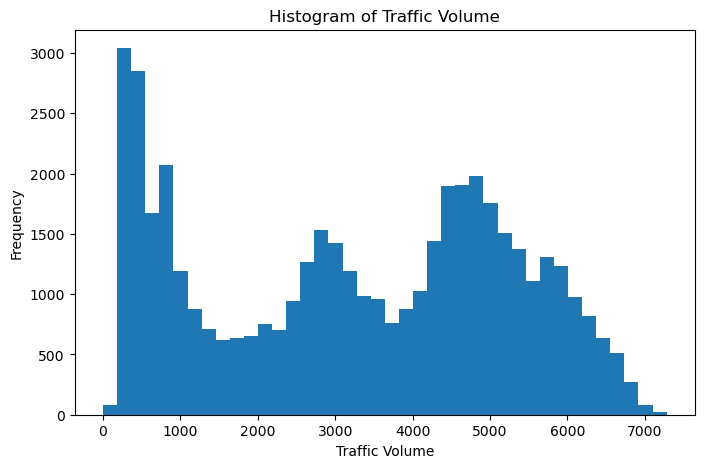

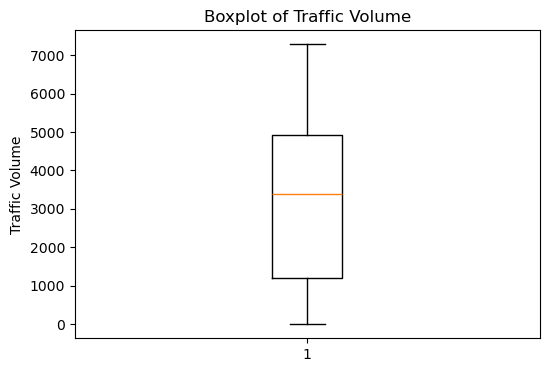

In [55]:
# Histogram of traffic_volume
plt.figure(figsize=(8,5))
plt.hist(df["traffic_volume"], bins=40)
plt.title("Histogram of Traffic Volume")
plt.xlabel("Traffic Volume")
plt.ylabel("Frequency")
plt.show()

# Boxplot of traffic_volume
plt.figure(figsize=(6,4))
plt.boxplot(df["traffic_volume"], vert=True)
plt.title("Boxplot of Traffic Volume")
plt.ylabel("Traffic Volume")
plt.show()

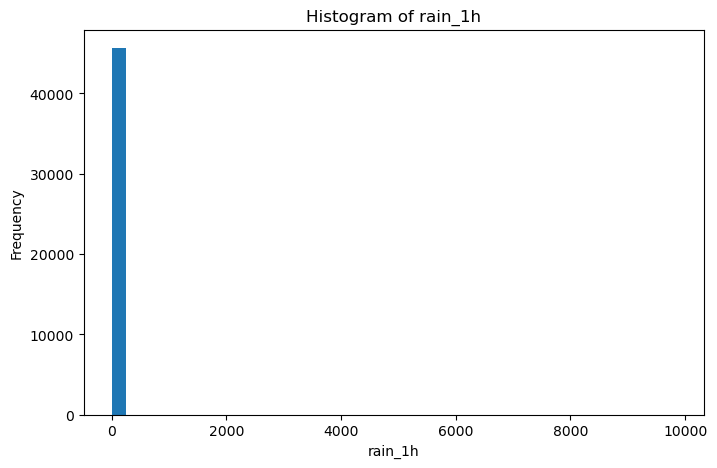

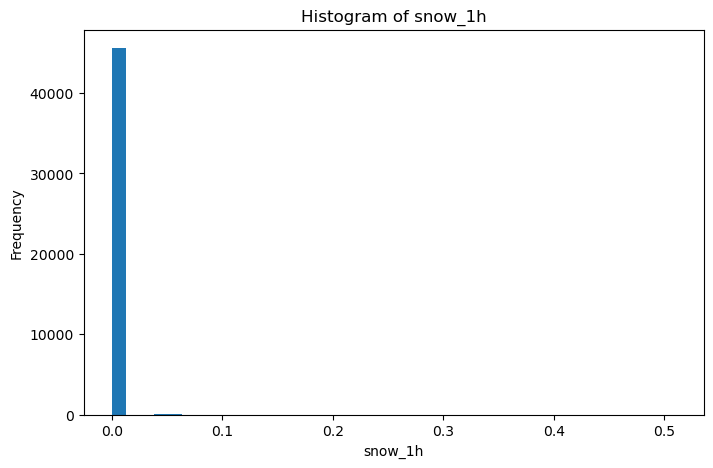

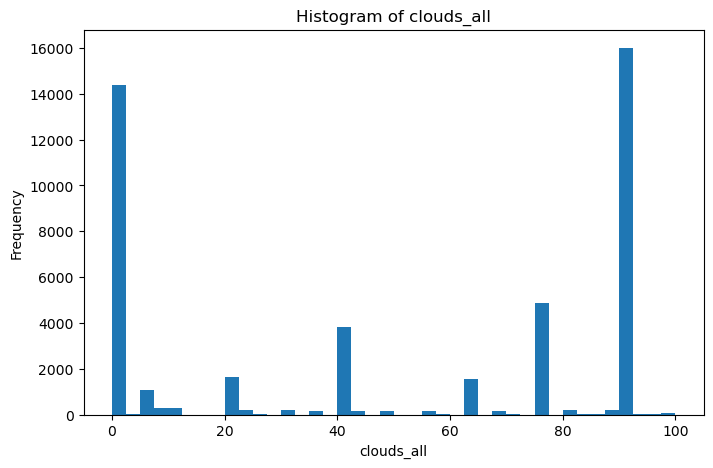

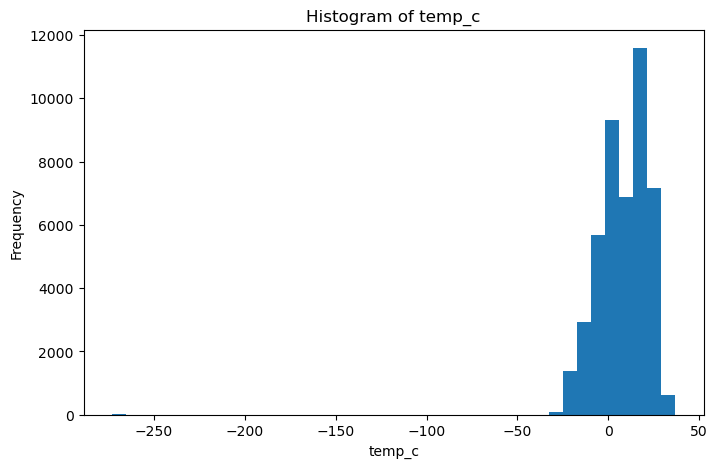

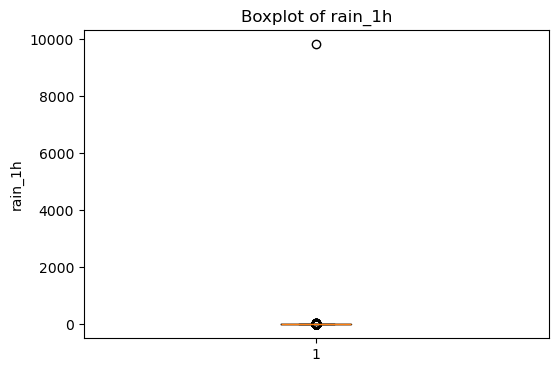

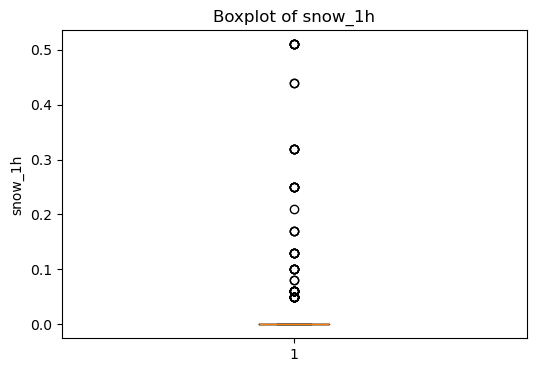

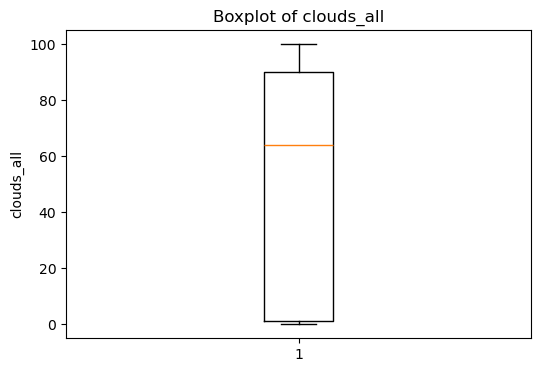

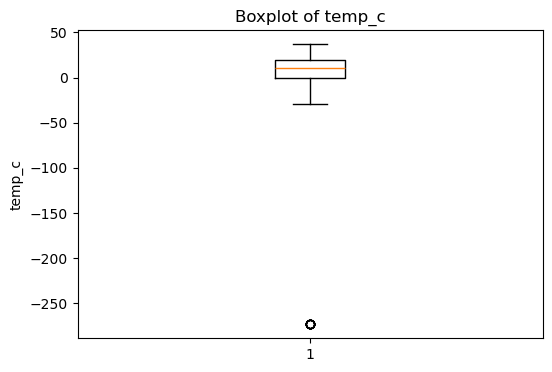

In [56]:


# List of variables to visualize
vars_to_plot = ["rain_1h", "snow_1h", "clouds_all", "temp_c"]

# Histograms
for var in vars_to_plot:
    plt.figure(figsize=(8,5))
    plt.hist(df[var], bins=40)
    plt.title(f"Histogram of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.show()

# Boxplots
for var in vars_to_plot:
    plt.figure(figsize=(6,4))
    plt.boxplot(df[var], vert=True)
    plt.title(f"Boxplot of {var}")
    plt.ylabel(var)
    plt.show()


In [57]:
df.columns


Index(['rain_1h', 'snow_1h', 'clouds_all', 'weather_description', 'date_time',
       'traffic_volume', 'year', 'month', 'holiday_binary',
       'weather_main_Clouds', 'weather_main_Drizzle', 'weather_main_Fog',
       'weather_main_Haze', 'weather_main_Mist', 'weather_main_Rain',
       'weather_main_Smoke', 'weather_main_Snow', 'weather_main_Squall',
       'weather_main_Thunderstorm', 'temp_c', 'hour', 'day_of_week',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos'],
      dtype='object')

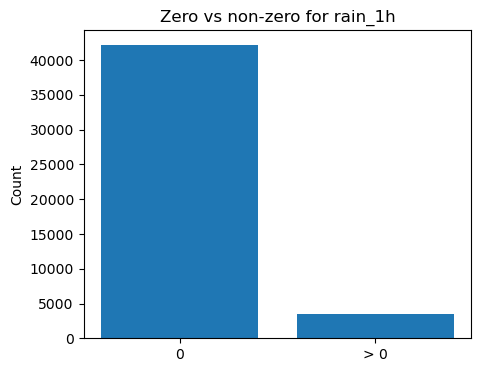

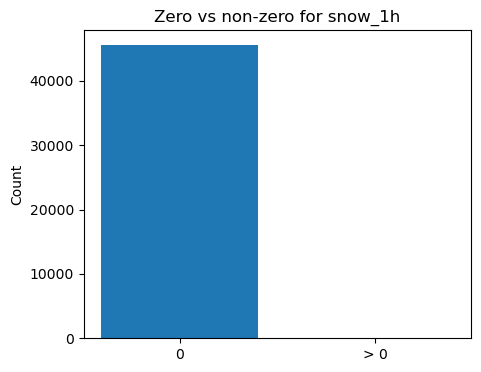

In [58]:
import matplotlib.pyplot as plt

# Helper function to plot zero vs non-zero counts
def plot_zero_vs_nonzero(series, var_name):
    # Create boolean mask
    zero_count = (series == 0).sum()
    nonzero_count = (series > 0).sum()

    plt.figure(figsize=(5,4))
    plt.bar(["0", "> 0"], [zero_count, nonzero_count])
    plt.title(f"Zero vs non-zero for {var_name}")
    plt.ylabel("Count")
    plt.show()

plot_zero_vs_nonzero(df["rain_1h"], "rain_1h")
plot_zero_vs_nonzero(df["snow_1h"], "snow_1h")


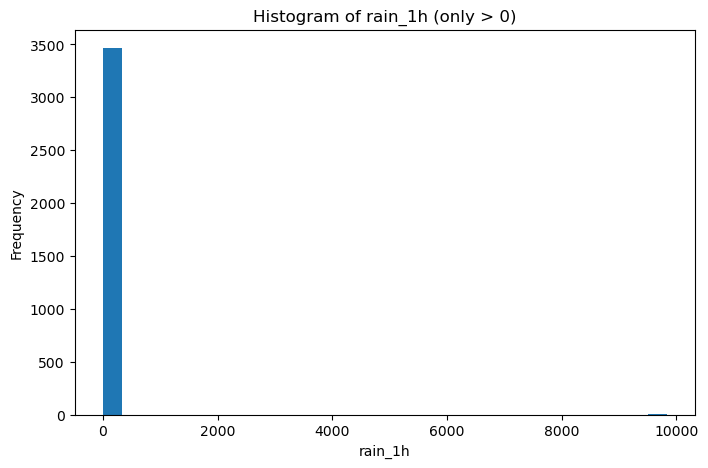

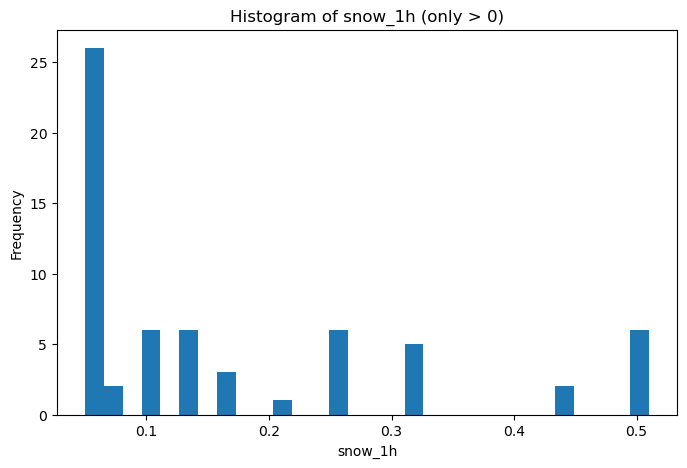

In [59]:
# Histogram of positive rain_1h values
rain_positive = df.loc[df["rain_1h"] > 0, "rain_1h"]

plt.figure(figsize=(8,5))
plt.hist(rain_positive, bins=30)
plt.title("Histogram of rain_1h (only > 0)")
plt.xlabel("rain_1h")
plt.ylabel("Frequency")
plt.show()

# Histogram of positive snow_1h values
snow_positive = df.loc[df["snow_1h"] > 0, "snow_1h"]

plt.figure(figsize=(8,5))
plt.hist(snow_positive, bins=30)
plt.title("Histogram of snow_1h (only > 0)")
plt.xlabel("snow_1h")
plt.ylabel("Frequency")
plt.show()


In [61]:
# check outliers:

# Look at the largest rain_1h values
df.sort_values("rain_1h", ascending=False)[
    ["date_time", "rain_1h", "snow_1h", "temp_c", "traffic_volume"]
].head(10)




,date_time,rain_1h,snow_1h,temp_c,traffic_volume
24872,2016-07-11 17:00:00,9831.30,0.0,28.96,5535
8247,2013-08-07 02:00:00,55.63,0.0,15.95,315
7179,2013-06-24 11:00:00,44.45,0.0,22.67,4802
25779,2016-08-16 17:00:00,31.75,0.0,24.56,4913
10806,2013-12-19 23:00:00,28.70,0.0,-8.65,1190
10807,2013-12-19 23:00:00,28.70,0.0,-8.65,1190
16505,2015-07-13 00:00:00,27.57,0.0,18.87,492
16506,2015-07-13 00:00:00,27.57,0.0,18.87,492
16504,2015-07-13 00:00:00,27.57,0.0,18.87,492
17439,2015-08-16 21:00:00,25.46,0.0,21.34,2118


In [62]:
# Look at the smallest temperatures
df.sort_values("temp_c", ascending=True)[
    ["date_time", "rain_1h", "snow_1h", "temp_c", "traffic_volume"]
].head(10)

,date_time,rain_1h,snow_1h,temp_c,traffic_volume
11901,2014-01-31 06:00:00,0.0,0.0,-273.15,5150
11898,2014-01-31 03:00:00,0.0,0.0,-273.15,361
11899,2014-01-31 04:00:00,0.0,0.0,-273.15,734
11949,2014-02-02 06:00:00,0.0,0.0,-273.15,739
11946,2014-02-02 03:00:00,0.0,0.0,-273.15,291
11947,2014-02-02 04:00:00,0.0,0.0,-273.15,284
11951,2014-02-02 08:00:00,0.0,0.0,-273.15,1670
11950,2014-02-02 07:00:00,0.0,0.0,-273.15,962
11948,2014-02-02 05:00:00,0.0,0.0,-273.15,434
11900,2014-01-31 05:00:00,0.0,0.0,-273.15,2557


In [63]:
# Manually remove obvious erroneous values

# 1) Define masks for the unrealistic values
#    (adjust the conditions if needed)
mask_rain_error = df["rain_1h"] > 1000       # the single huge rain value
mask_temp_error = df["temp_c"] <= -200       # the -273.15 °C rows

# 2) Optionally inspect them before dropping
display(df[mask_rain_error][["date_time", "rain_1h", "temp_c", "traffic_volume"]])
display(df[mask_temp_error][["date_time", "rain_1h", "temp_c", "traffic_volume"]])

# 3) Drop those rows from df
df = df[~(mask_rain_error | mask_temp_error)].copy()

print("New shape after manual removal:", df.shape)


,date_time,rain_1h,temp_c,traffic_volume
24872,2016-07-11 17:00:00,9831.3,28.96,5535


,date_time,rain_1h,temp_c,traffic_volume
11898,2014-01-31 03:00:00,0.0,-273.15,361
11899,2014-01-31 04:00:00,0.0,-273.15,734
11900,2014-01-31 05:00:00,0.0,-273.15,2557
11901,2014-01-31 06:00:00,0.0,-273.15,5150
11946,2014-02-02 03:00:00,0.0,-273.15,291
11947,2014-02-02 04:00:00,0.0,-273.15,284
11948,2014-02-02 05:00:00,0.0,-273.15,434
11949,2014-02-02 06:00:00,0.0,-273.15,739
11950,2014-02-02 07:00:00,0.0,-273.15,962
11951,2014-02-02 08:00:00,0.0,-273.15,1670


New shape after manual removal: (45634, 28)


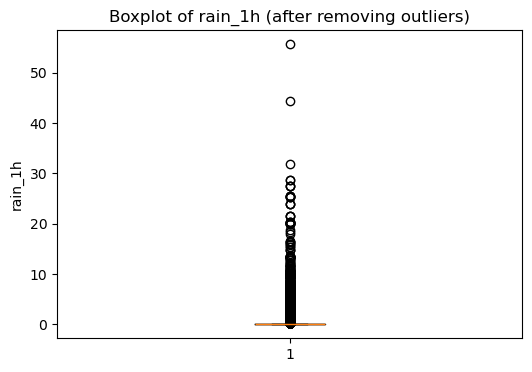

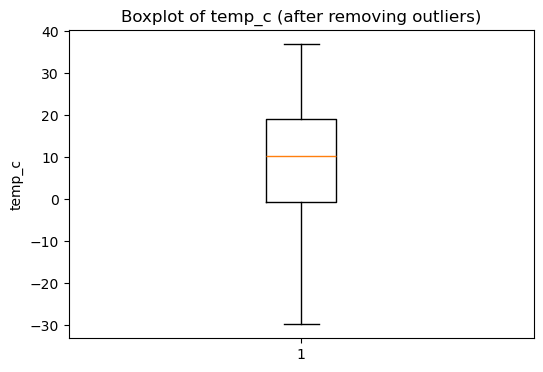

In [64]:
import matplotlib.pyplot as plt

# Boxplot for rain_1h
plt.figure(figsize=(6,4))
plt.boxplot(df["rain_1h"], vert=True)
plt.title("Boxplot of rain_1h (after removing outliers)")
plt.ylabel("rain_1h")
plt.show()

# Boxplot for temp_c
plt.figure(figsize=(6,4))
plt.boxplot(df["temp_c"], vert=True)
plt.title("Boxplot of temp_c (after removing outliers)")
plt.ylabel("temp_c")
plt.show()
